# Human Pose Detection with OpenCV (OpenPose COCO) and Ergonomic Risk Scores

This notebook uses **OpenCV's DNN** module with the **OpenPose COCO** model to detect human keypoints from an image and computes simple, transparent ergonomic risk scores (trunk, neck, knees, shoulders) plus an overall 0–100 score.

**Notes**
- You need the OpenPose COCO model files locally:
  - `pose_deploy_linevec.prototxt`
  - `pose_iter_440000.caffemodel`
- The risk logic here is heuristic and intended as a clear baseline. Tune thresholds to match your application (e.g., lifting tasks, seated posture, etc.).


In [4]:
# (Optional) Install dependencies here if your environment is missing them
# Uncomment as needed:
# !pip install opencv-python numpy matplotlib
%pip install --upgrade ipywidgets==8.1.2 jupyterlab_widgets==3.0.10

In [5]:
import os, math, json
from typing import Dict, Optional, Tuple
import cv2
import numpy as np
import matplotlib.pyplot as plt

BODY_PARTS = {
    0: "Nose", 1: "Neck", 2: "RShoulder", 3: "RElbow", 4: "RWrist",
    5: "LShoulder", 6: "LElbow", 7: "LWrist", 8: "RHip", 9: "RKnee",
    10: "RAnkle", 11: "LHip", 12: "LKnee", 13: "LAnkle", 14: "REye",
    15: "LEye", 16: "REar", 17: "LEar", 18: "Background",
}

POSE_PAIRS = [
    (1, 2), (2, 3), (3, 4),      # Right arm
    (1, 5), (5, 6), (6, 7),      # Left arm
    (1, 8), (8, 9), (9, 10),     # Right leg
    (1, 11), (11, 12), (12, 13), # Left leg
    (1, 0), (0, 14), (14, 16),   # Face right
    (0, 15), (15, 17)            # Face left
]

def _argmax_with_confidence(heatmap: np.ndarray) -> Tuple[Tuple[int, int], float]:
    _, conf, _, point = cv2.minMaxLoc(heatmap)
    return (int(point[0]), int(point[1])), float(conf)

def extract_keypoints(heatmaps: np.ndarray, frame_w: int, frame_h: int, conf_thresh: float = 0.1) -> Dict[str, Optional[Tuple[int, int, float]]]:
    n_parts = len(BODY_PARTS) - 1
    out_h, out_w = heatmaps.shape[2], heatmaps.shape[3]
    keypoints: Dict[str, Optional[Tuple[int, int, float]]] = {}
    for i in range(n_parts):
        heatmap = heatmaps[0, i, :, :]
        (x, y), conf = _argmax_with_confidence(heatmap)
        x = int((frame_w * x) / out_w)
        y = int((frame_h * y) / out_h)
        name = BODY_PARTS[i]
        keypoints[name] = (x, y, conf) if conf > conf_thresh else None
    return keypoints

def _angle_between(v1: np.ndarray, v2: np.ndarray) -> float:
    if np.linalg.norm(v1) < 1e-6 or np.linalg.norm(v2) < 1e-6:
        return float("nan")
    cos_ang = np.clip(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)), -1.0, 1.0)
    return math.degrees(math.acos(cos_ang))

def _line_angle_vs_vertical(p_from: np.ndarray, p_to: np.ndarray) -> float:
    v = p_to - p_from
    vertical = np.array([0.0, 1.0])
    return float(_angle_between(v, vertical))

def _joint_angle(a: np.ndarray, b: np.ndarray, c: np.ndarray) -> float:
    return _angle_between(a - b, c - b)

def _pt(kps: Dict[str, Optional[Tuple[int, int, float]]], name: str) -> Optional[np.ndarray]:
    v = kps.get(name)
    if v is None:
        return None
    return np.array([float(v[0]), float(v[1])], dtype=np.float32)

def compute_metrics(kps: Dict[str, Optional[Tuple[int, int, float]]]) -> Dict[str, float]:
    metrics: Dict[str, float] = {}
    neck = _pt(kps, "Neck"); nose = _pt(kps, "Nose")
    lhip = _pt(kps, "LHip"); rhip = _pt(kps, "RHip")
    lshould = _pt(kps, "LShoulder"); rshould = _pt(kps, "RShoulder")
    lelbow = _pt(kps, "LElbow"); relbow = _pt(kps, "RElbow")
    lankle = _pt(kps, "LAnkle"); rankle = _pt(kps, "RAnkle")
    lknee = _pt(kps, "LKnee"); rknee = _pt(kps, "RKnee")

    if lhip is not None and rhip is not None:
        mid_hip = (lhip + rhip) / 2.0
    else:
        mid_hip = lhip if lhip is not None else rhip

    if lshould is not None and rshould is not None:
        mid_sh = (lshould + rshould) / 2.0
    else:
        mid_sh = lshould if lshould is not None else rshould

    trunk_flexion = float("nan")
    if (mid_hip is not None) and (neck is not None):
        trunk_flexion = _line_angle_vs_vertical(mid_hip, neck)
    elif (lhip is not None) and (lshould is not None):
        trunk_flexion = _line_angle_vs_vertical(lhip, lshould)
    elif (rhip is not None) and (rshould is not None):
        trunk_flexion = _line_angle_vs_vertical(rhip, rshould)
    metrics["trunk_flexion"] = trunk_flexion

    neck_flexion = float("nan")
    if neck is not None and nose is not None:
        neck_flexion = _line_angle_vs_vertical(neck, nose)
    metrics["neck_flexion"] = neck_flexion

    knee_left = float("nan")
    if lhip is not None and lknee is not None and lankle is not None:
        knee_left = _joint_angle(lhip, lknee, lankle)
    metrics["knee_left"] = knee_left

    knee_right = float("nan")
    if rhip is not None and rknee is not None and rankle is not None:
        knee_right = _joint_angle(rhip, rknee, rankle)
    metrics["knee_right"] = knee_right

    shoulder_left_elev = float("nan")
    if lhip is not None and lshould is not None and lelbow is not None:
        shoulder_left_elev = _angle_between(lshould - lhip, lelbow - lshould)
    metrics["shoulder_left_elev"] = shoulder_left_elev

    shoulder_right_elev = float("nan")
    if rhip is not None and rshould is not None and relbow is not None:
        shoulder_right_elev = _angle_between(rshould - rhip, relbow - rshould)
    metrics["shoulder_right_elev"] = shoulder_right_elev

    return metrics

def _score_angle_linear(angle: float, low: float, high: float, cap: int) -> int:
    if math.isnan(angle):
        return cap // 2
    if angle <= low:
        return 0
    if angle >= high:
        return cap
    frac = (angle - low) / (high - low + 1e-9)
    return int(round(frac * cap))

def score_metrics(metrics: Dict[str, float]) -> Dict[str, int]:
    scores: Dict[str, int] = {}
    scores["trunk_flexion"] = _score_angle_linear(metrics.get("trunk_flexion", float("nan")), 10, 45, 25)
    scores["neck_flexion"]  = _score_angle_linear(metrics.get("neck_flexion", float("nan")), 10, 35, 25)

    def knee_score(a: float) -> int:
        if math.isnan(a):
            return 12
        if a >= 160:
            return 0
        if a <= 120:
            return 25
        frac = (160 - a) / (160 - 120 + 1e-9)
        return int(round(frac * 25))

    scores["knee_left"]  = knee_score(metrics.get("knee_left", float("nan")))
    scores["knee_right"] = knee_score(metrics.get("knee_right", float("nan")))
    scores["shoulder_left_elev"]  = _score_angle_linear(metrics.get("shoulder_left_elev", float("nan")), 20, 90, 25)
    scores["shoulder_right_elev"] = _score_angle_linear(metrics.get("shoulder_right_elev", float("nan")), 20, 90, 25)

    overall = sum(scores.values())
    overall = int(round(100 * overall / 150))
    scores["overall"] = max(0, min(100, overall))
    return scores

def draw_skeleton(frame: np.ndarray, kps: Dict[str, Optional[Tuple[int, int, float]]]) -> np.ndarray:
    out = frame.copy()
    for i, name in BODY_PARTS.items():
        if i == 18:
            continue
        kp = kps.get(name)
        if kp is None:
            continue
        x, y, conf = kp
        cv2.circle(out, (int(x), int(y)), 4, (0, 255, 255), thickness=-1, lineType=cv2.LINE_AA)
        cv2.putText(out, name, (int(x)+5, int(y)-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,0,0), 1, cv2.LINE_AA)
    for a, b in POSE_PAIRS:
        pa = kps.get(BODY_PARTS[a]); pb = kps.get(BODY_PARTS[b])
        if pa is None or pb is None:
            continue
        ax, ay, _ = pa; bx, by, _ = pb
        cv2.line(out, (int(ax), int(ay)), (int(bx), int(by)), (0, 255, 0), 2, cv2.LINE_AA)
    return out

def overlay_scores(img: np.ndarray, metrics: Dict[str, float], scores: Dict[str, int]) -> None:
    lines = [
        f"Trunk flexion: {metrics['trunk_flexion']:.1f} deg  | score {scores['trunk_flexion']}",
        f"Neck flexion:  {metrics['neck_flexion']:.1f} deg  | score {scores['neck_flexion']}",
        f"Knee L:        {metrics['knee_left']:.1f} deg     | score {scores['knee_left']}",
        f"Knee R:        {metrics['knee_right']:.1f} deg    | score {scores['knee_right']}",
        f"Shoulder L:    {metrics['shoulder_left_elev']:.1f} deg | score {scores['shoulder_left_elev']}",
        f"Shoulder R:    {metrics['shoulder_right_elev']:.1f} deg| score {scores['shoulder_right_elev']}",
        f"OVERALL:       {scores['overall']} / 100",
    ]
    pad = 8; line_h = 20; panel_w = 360; panel_h = pad*2 + line_h*len(lines)
    cv2.rectangle(img, (10, 10), (10 + panel_w, 10 + panel_h), (255, 255, 255), thickness=-1)
    cv2.rectangle(img, (10, 10), (10 + panel_w, 10 + panel_h), (0, 0, 0), thickness=1)
    for i, text in enumerate(lines):
        y = 10 + pad + (i+1)*line_h
        cv2.putText(img, text, (18, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)

def infer_pose(image: np.ndarray, net: cv2.dnn_Net, in_width: int = 368, in_height: int = 368) -> np.ndarray:
    blob = cv2.dnn.blobFromImage(image, 1.0/255, (in_width, in_height), (0,0,0), swapRB=False, crop=False)
    net.setInput(blob)
    return net.forward()


## Configure paths and run
Set the paths below to your image and the OpenPose COCO model files. Then run this cell.

Overall risk: 83
Per-metric: {'trunk_flexion': 25, 'neck_flexion': 25, 'knee_left': 12, 'knee_right': 12, 'shoulder_left_elev': 25, 'shoulder_right_elev': 25}
Saved: C:\Users\zhang\INOVATION\pose_output.png and C:\Users\zhang\INOVATION\pose_risk.json


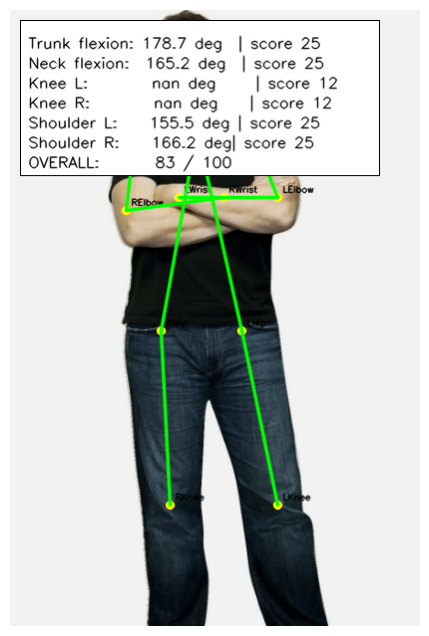

In [7]:
# === Edit these paths ===
IMAGE_PATH = "C:/Users/zhang/Desktop/musk.png" # e.g., "sample.jpg"
PROTOTXT_PATH = "C:/Users/zhang/Desktop/innovation presentation/pose_deploy_linevec.prototxt"
CAFFEMODEL_PATH = r'C:\Users\zhang\Desktop\innovation presentation\openpose-master\models\pose\coco\pose_iter_440000.caffemodel'

# Inference params
CONF_THRESH = 0.10
INPUT_SIZE = 368  # 256, 368, 432 are common

# Output files
OUT_IMAGE = "pose_output.png"
OUT_JSON  = "pose_risk.json"

assert os.path.exists(IMAGE_PATH), f"Image not found: {IMAGE_PATH}"
assert os.path.exists(PROTOTXT_PATH), f"Prototxt not found: {PROTOTXT_PATH}"
assert os.path.exists(CAFFEMODEL_PATH), f"Caffemodel not found: {CAFFEMODEL_PATH}"

frame = cv2.imread(IMAGE_PATH)
if frame is None:
    raise RuntimeError("Failed to read image. Unsupported format or corrupt file.")
h, w = frame.shape[:2]

net = cv2.dnn.readNetFromCaffe(PROTOTXT_PATH, CAFFEMODEL_PATH)
heatmaps = infer_pose(frame, net, in_width=INPUT_SIZE, in_height=INPUT_SIZE)
kps = extract_keypoints(heatmaps, frame_w=w, frame_h=h, conf_thresh=CONF_THRESH)
metrics = compute_metrics(kps)
scores  = score_metrics(metrics)

vis = draw_skeleton(frame, kps)
overlay_scores(vis, metrics, scores)

# Save outputs
cv2.imwrite(OUT_IMAGE, vis)
payload = {
    "metrics_degrees": {k: (None if math.isnan(v) else float(v)) for k, v in metrics.items()},
    "risk_scores_0_25_each": {k: int(v) for k, v in scores.items() if k != "overall"},
    "overall_risk_0_100": int(scores["overall"]),
    "keypoints": {k: (None if v is None else {"x": int(v[0]), "y": int(v[1]), "conf": float(v[2])}) for k, v in kps.items()},
    "image": os.path.abspath(IMAGE_PATH),
    "output_image": os.path.abspath(OUT_IMAGE)
}
with open(OUT_JSON, "w", encoding="utf-8") as f:
    json.dump(payload, f, indent=2)

print("Overall risk:", scores["overall"]) 
print("Per-metric:", {k: v for k, v in scores.items() if k != "overall"})
print("Saved:", os.path.abspath(OUT_IMAGE), "and", os.path.abspath(OUT_JSON))

# Display the annotated image inline
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


## Interpreting and tuning risk scores
Heuristics used (tweak inside `score_metrics`):
- **Trunk flexion**: 0 at ≤10°, 25 at ≥45°
- **Neck flexion**:  0 at ≤10°, 25 at ≥35°
- **Knees** (each):  0 at ≥160°, 25 at ≤120° (more bend → higher risk)
- **Shoulder elevation**: 0 at ≤20°, 25 at ≥90°

The overall score scales the sum of the six 0–25 components to 0–100. Adjust weights/thresholds per your domain or replace with a formal method (e.g., **RULA/REBA** mapping).

# 🧭 Personalized Posture Assistant

This section adds an interactive UI to personalize recommendations and generate **posture adjustment commands** based on risk scores. Use the widgets to set your profile and live risk inputs. The output is a structured set of commands you can feed into downstream systems (e.g., a robot, an exoskeleton, or a posture coach).

**How to use**
1. Adjust your personal profile (height/weight/goals).
2. Input or stream risk scores per body region.
3. Click **Generate Commands** to get recommended joint targets and ergonomic actions.

> Tip: Replace the dummy risk scores with your model outputs to drive this UI in real time.

In [10]:
from dataclasses import dataclass
from typing import Dict, Any
import math
import ipywidgets as w
from IPython.display import display, clear_output

# --- Personal profile (defaults can be pre-filled) ---
# Pulled from known context when available; feel free to change.
DEFAULT_HEIGHT_CM = 174  # user default
DEFAULT_WEIGHT_KG = 75   # user default

@dataclass
class Profile:
    height_cm: float
    weight_kg: float
    goal: str  # 'pain_reduction', 'performance', 'fatigue_management'

@dataclass
class PostureRisk:
    neck: float
    upper_back: float
    lower_back: float
    shoulders: float
    wrists: float
    hips: float
    knees: float

def normalize_score(x: float) -> float:
    """Clip to [0, 1] just in case."""
    return max(0.0, min(1.0, float(x)))

def bucket(score: float) -> str:
    s = normalize_score(score)
    if s < 0.25:
        return 'low'
    if s < 0.5:
        return 'moderate'
    if s < 0.75:
        return 'high'
    return 'very_high'

def personalize_gain(profile: Profile) -> float:
    """Simple personalization factor using BMI and goal.
    You can replace with your own learned mapping.
    """
    h_m = profile.height_cm / 100
    bmi = profile.weight_kg / (h_m * h_m)
    # Baseline gain
    gain = 1.0
    # Slightly higher gain for pain reduction and fatigue management
    if profile.goal == 'pain_reduction':
        gain *= 1.10
    elif profile.goal == 'fatigue_management':
        gain *= 1.05
    # Adjust by BMI band (gentle scaling)
    if bmi < 18.5:
        gain *= 0.95
    elif bmi > 27:
        gain *= 1.08
    return gain

def generate_posture_commands(risks: PostureRisk, profile: Profile) -> Dict[str, Any]:
    """
    Convert risk scores into explicit posture adjustment commands.
    Returns a structured dict with joint targets, ergonomic actions, and reminders.
    """
    g = personalize_gain(profile)

    def scale(deg_low, deg_high, r):
        # interpolate by normalized risk and scale by personalization gain
        rr = normalize_score(r)
        base = deg_low + (deg_high - deg_low) * rr
        return round(base * g, 2)

    cmds = {
        'joint_targets_deg': {
            # Positive means flexion/fwd bend where meaningful; negative = extension.
            'neck_flexion': -scale(2, 10, risks.neck),   # encourage neutral / slight extension if neck risk high
            'thoracic_extension': scale(0, 8, risks.upper_back),
            'lumbar_extension': scale(0, 10, risks.lower_back),
            'shoulder_depression': scale(0, 6, risks.shoulders),
            'shoulder_retraction': scale(0, 10, risks.shoulders),
            'wrist_extension': -scale(0, 10, risks.wrists),
            'pelvic_anteversion': scale(0, 6, risks.hips),
            'hip_abduction': scale(0, 5, risks.hips),
            'knee_extension': scale(0, 5, risks.knees),
        },
        'ergonomic_actions': [],
        'reminders': [],
        'risk_buckets': {
            'neck': bucket(risks.neck),
            'upper_back': bucket(risks.upper_back),
            'lower_back': bucket(risks.lower_back),
            'shoulders': bucket(risks.shoulders),
            'wrists': bucket(risks.wrists),
            'hips': bucket(risks.hips),
            'knees': bucket(risks.knees),
        },
    }

    # Ergonomic actions based on buckets
    if cmds['risk_buckets']['neck'] in ('high', 'very_high'):
        cmds['ergonomic_actions'].append('Raise or angle workpiece to reduce downward neck flexion; keep chin slightly tucked and maintain neutral neck.')
    if cmds['risk_buckets']['upper_back'] in ('high', 'very_high'):
        cmds['ergonomic_actions'].append('Add standing thoracic extension micro-break: 5 reps x 3 seconds; avoid prolonged forward hunching over the task.')
    if cmds['risk_buckets']['lower_back'] in ('moderate', 'high', 'very_high'):
        cmds['ergonomic_actions'].append('Adjust work height to elbow level; avoid repeated trunk flexion; maintain slight lumbar curve and engage core lightly.')
    if cmds['risk_buckets']['shoulders'] in ('high', 'very_high'):
        cmds['ergonomic_actions'].append('Lower work surface or bring task closer; keep upper arms near torso; avoid sustained shoulder elevation or reaching above shoulder height.')
    if cmds['risk_buckets']['wrists'] in ('moderate', 'high', 'very_high'):
        cmds['ergonomic_actions'].append( 'Keep tools/workpiece at neutral wrist height; avoid excessive wrist deviation; consider angled handles or fixtures.')
    if cmds['risk_buckets']['hips'] in ('high', 'very_high'):
        cmds['ergonomic_actions'].append('Open hip angle to 100–110°; slight anterior pelvic tilt.')
    if cmds['risk_buckets']['knees'] in ('moderate', 'high', 'very_high'):
        cmds['ergonomic_actions'].append('Keep knees ~90–100°; consider footrest to unload.')

    # Reminders tailored by goal
    if profile.goal == 'pain_reduction':
        cmds['reminders'].append('Take a 1–2 min micro-break every 25–30 min.')
    elif profile.goal == 'fatigue_management':
        cmds['reminders'].append('Alternate sit/stand every 45–60 min.')
    else:
        cmds['reminders'].append('Include 1–2 posture drills per hour for performance.')

    return cmds

# --- Widgets ---
height_w = w.IntSlider(description='Height (cm)', min=140, max=210, value=DEFAULT_HEIGHT_CM)
weight_w = w.IntSlider(description='Weight (kg)', min=45, max=120, value=DEFAULT_WEIGHT_KG)
goal_w = w.ToggleButtons(options=[('Pain reduction','pain_reduction'), ('Performance','performance'), ('Fatigue mgmt','fatigue_management')], value='pain_reduction', description='Goal')

neck_w = w.FloatSlider(description='Neck risk', min=0.0, max=1.0, step=0.01, value=0.4)
upper_back_w = w.FloatSlider(description='Upper back risk', min=0.0, max=1.0, step=0.01, value=0.5)
lower_back_w = w.FloatSlider(description='Lower back risk', min=0.0, max=1.0, step=0.01, value=0.6)
shoulders_w = w.FloatSlider(description='Shoulders risk', min=0.0, max=1.0, step=0.01, value=0.5)
wrists_w = w.FloatSlider(description='Wrists risk', min=0.0, max=1.0, step=0.01, value=0.3)
hips_w = w.FloatSlider(description='Hips risk', min=0.0, max=1.0, step=0.01, value=0.4)
knees_w = w.FloatSlider(description='Knees risk', min=0.0, max=1.0, step=0.01, value=0.2)

out = w.Output()

def on_generate(_):
    with out:
        clear_output()
        profile = Profile(height_cm=height_w.value, weight_kg=weight_w.value, goal=goal_w.value)
        risks = PostureRisk(
            neck=neck_w.value,
            upper_back=upper_back_w.value,
            lower_back=lower_back_w.value,
            shoulders=shoulders_w.value,
            wrists=wrists_w.value,
            hips=hips_w.value,
            knees=knees_w.value,
        )
        cmds = generate_posture_commands(risks, profile)
        print('=== Posture Commands ===')
        for k, v in cmds['joint_targets_deg'].items():
            print(f"{k}: {v}°")
        print('\nErgonomic Actions:')
        for a in cmds['ergonomic_actions']:
            print(f"- {a}")
        print('\nReminders:')
        for r in cmds['reminders']:
            print(f"- {r}")
        print('\nRisk Buckets:')
        for k, v in cmds['risk_buckets'].items():
            print(f"{k}: {v}")

btn = w.Button(description='Generate Commands', button_style='primary')
btn.on_click(on_generate)

ui = w.VBox([
    w.HTML('<h3>Personal Profile</h3>'),
    w.HBox([height_w, weight_w, goal_w]),
    w.HTML('<h3>Risk Scores (0–1)</h3>'),
    w.GridBox([
        neck_w, upper_back_w, lower_back_w,
        shoulders_w, wrists_w, hips_w, knees_w
    ], layout=w.Layout(grid_template_columns='repeat(3, minmax(300px, 1fr))', grid_gap='10px')),
    btn,
    out,
])
display(ui)


In [11]:
# Programmatic API example: integrate your model's risk output here
profile = Profile(height_cm=174, weight_kg=75, goal='pain_reduction')
risks = PostureRisk(neck=0.72, upper_back=0.35, lower_back=0.81, shoulders=0.55, wrists=0.48, hips=0.62, knees=0.20)
cmds = generate_posture_commands(risks, profile)
cmds

{'joint_targets_deg': {'neck_flexion': -8.54,
  'thoracic_extension': 3.08,
  'lumbar_extension': 8.91,
  'shoulder_depression': 3.63,
  'shoulder_retraction': 6.05,
  'wrist_extension': -5.28,
  'pelvic_anteversion': 4.09,
  'hip_abduction': 3.41,
  'knee_extension': 1.1},
 'ergonomic_actions': ['Raise or angle workpiece to reduce downward neck flexion; keep chin slightly tucked and maintain neutral neck.',
  'Adjust work height to elbow level; avoid repeated trunk flexion; maintain slight lumbar curve and engage core lightly.',
  'Lower work surface or bring task closer; keep upper arms near torso; avoid sustained shoulder elevation or reaching above shoulder height.',
  'Keep tools/workpiece at neutral wrist height; avoid excessive wrist deviation; consider angled handles or fixtures.',
  'Open hip angle to 100–110°; slight anterior pelvic tilt.'],
 'reminders': ['Take a 1–2 min micro-break every 25–30 min.'],
 'risk_buckets': {'neck': 'high',
  'upper_back': 'moderate',
  'lower_ba

### Notes
- Replace the slider inputs with your **live model outputs** to drive `generate_posture_commands(...)`.
- The numeric mappings (angles and actions) are **sane defaults**; feel free to calibrate to your hardware or clinician guidance.
- `personalize_gain` is a placeholder—swap in your learned personalization strategy when available.